# Input dataset

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet101
from keras import optimizers
from keras.models import Model

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import numpy as np

# Experiment settings
train_path_baseline = '/root/data/imagenette_baseline_50/train/'
val_path_baseline = '/root/data/imagenette_baseline_50/val'
train_path_ours = '/root/data/imagenette_ours_50/train/'
val_path_ours = '/root/data/imagenette_ours_50/val'
batch_size = 100
number_of_classes = 10
target_size = (224, 224)

2023-11-17 16:42:24.465281: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 16:42:25.694666: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator_baseline = train_datagen.flow_from_directory(
    train_path_baseline,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True # set True to train the model from scratch
    )

train_generator_ours = train_datagen.flow_from_directory(
    train_path_ours,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True # set True to train the model from scratch
    )

Found 9989 images belonging to 10 classes.
Found 9972 images belonging to 10 classes.


In [3]:
val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    val_path_baseline,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
    )

validation_generator = val_datagen.flow_from_directory(
    val_path_ours,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
    )

Found 3925 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


# Train from scratch

In [4]:
model_baseline = ResNet101(weights=None,
                 include_top=True,
                 input_shape=(224, 224, 3),
                 classes=number_of_classes)

model_ours = ResNet101(weights=None,
                 include_top=True,
                 input_shape=(224, 224, 3),
                 classes=number_of_classes)

2023-11-17 16:43:02.085981: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:67:01.0, compute capability: 7.0


In [5]:
model_baseline.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),  
              metrics=['acc'])

NameError: name 'model' is not defined

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples / batch_size,  # steps = total samples / batch size
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50)

In [10]:
model.save('./model/resnet101_ours_50.h5')

/root/miniconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Using pretrained model

In [6]:
from tensorflow.keras.models import load_model
# Load the model
pretrained_model_baseline = './model/resnet101_baseline_50.h5'
pretrained_model_ours = './model/resnet101_ours_50.h5'

model_baseline = load_model(pretrained_model_baseline)
model_ours = load_model(pretrained_model_ours)

# Extracting final features

In [7]:
original_datagen = ImageDataGenerator(rescale=1./255)
original_generator = original_datagen.flow_from_directory(
    '/root/data/imagenette/train/',
    target_size=(224, 224),
    batch_size=50,
    class_mode='categorical',
    shuffle=False) # set false here

Found 9471 images belonging to 10 classes.


In [10]:
feature_extractor_baseline = Model(inputs=model_baseline.input, outputs=model_baseline.layers[-2].output)
train_features_baseline = feature_extractor_baseline.predict(original_generator)

feature_extractor_ours = Model(inputs=model_ours.input, outputs=model_ours.layers[-2].output)
train_features_ours = feature_extractor_ours.predict(original_generator)

2023-11-17 16:49:17.153695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


190/190 [==============================] - 39s 192ms/step


In [27]:
distilled_data_baseline = '/root/data/Baseline_v2_50ipc/'
distilled_data_ours = '/root/data/Ours_v2_50ipc/'

dis_datagen = ImageDataGenerator(rescale=1./255)
distilled_generator_baseline = dis_datagen.flow_from_directory(
    distilled_data_baseline,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False) # set false here

distilled_generator_ours = dis_datagen.flow_from_directory(
    distilled_data_ours,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


distilled_features_baseline = feature_extractor_baseline.predict(distilled_generator_baseline)
distilled_features_ours = feature_extractor_ours.predict(distilled_generator_ours)

Found 500 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
5/5 [==============================] - 2s 327ms/step


# Visualization

In [10]:
# Using t-SNE method
tsne = TSNE(random_state=40, n_components=2,verbose=0, perplexity=30)
train_features_2d = tsne.fit_transform(train_features)

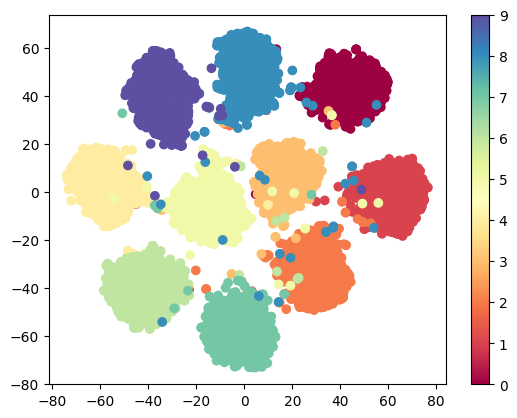

In [15]:
# Get the plot with original dataset
train_labels = original_generator.classes

plt.scatter(train_features_2d[:, 0], train_features_2d[:, 1], c=train_labels, cmap='Spectral')
plt.colorbar()
plt.show()

In [29]:
# Get the plot with both the original and the synthetic dataset
labels = np.concatenate((original_generator.classes, distilled_generator.classes))
features_baseline = np.concatenate((train_features_baseline,distilled_features_baseline))
features_ours = np.concatenate((train_features_ours,distilled_features_ours))

tsne = TSNE(random_state=40, n_components=2,verbose=0, perplexity=30)
features_2d_baseline = tsne.fit_transform(features_baseline)
features_2d_ours = tsne.fit_transform(features_ours)

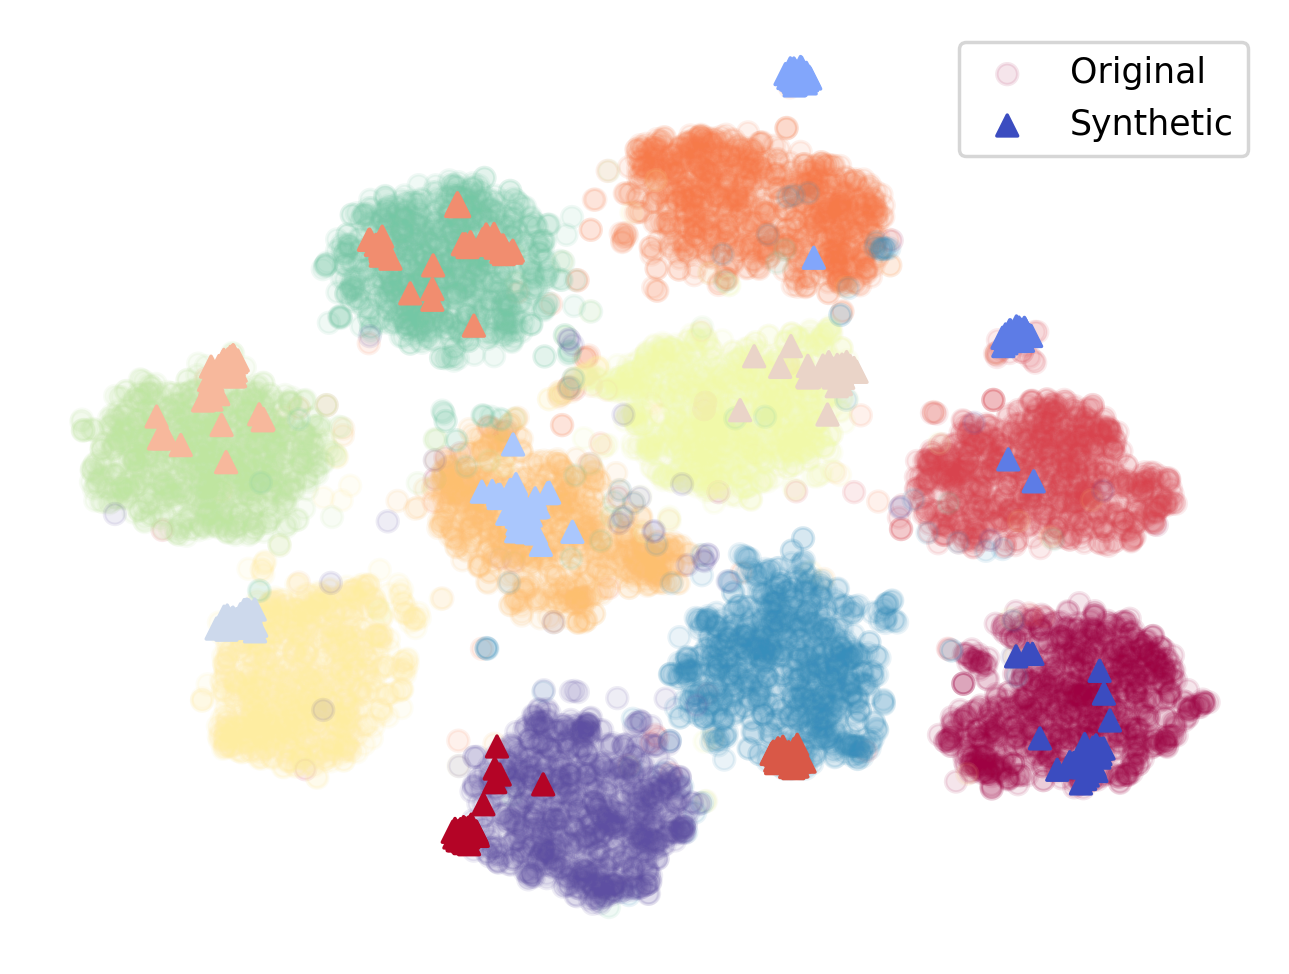

In [30]:
original_features_2d_baseline = features_2d_baseline[:len(train_features_baseline)]
distilled_features_2d_baseline = features_2d_baseline[len(train_features_baseline):]
original_labels = labels[:len(train_features_baseline)]
distilled_labels = labels[len(train_features_baseline):]

fig, ax = plt.subplots(dpi=250)
scatter1 = ax.scatter(original_features_2d_baseline[:, 0], original_features_2d_baseline[:, 1], cmap='Spectral', c=original_labels, alpha=0.1, label='Original')
# cbar1 = plt.colorbar(scatter1, ax=ax)
scatter2 = ax.scatter(distilled_features_2d_baseline[:, 0], distilled_features_2d_baseline[:, 1], cmap='coolwarm', c=distilled_labels, marker='^', label='Synthetic')
# cbar2 = plt.colorbar(scatter2, ax=ax)

plt.legend()
plt.axis('off')
plt.show()

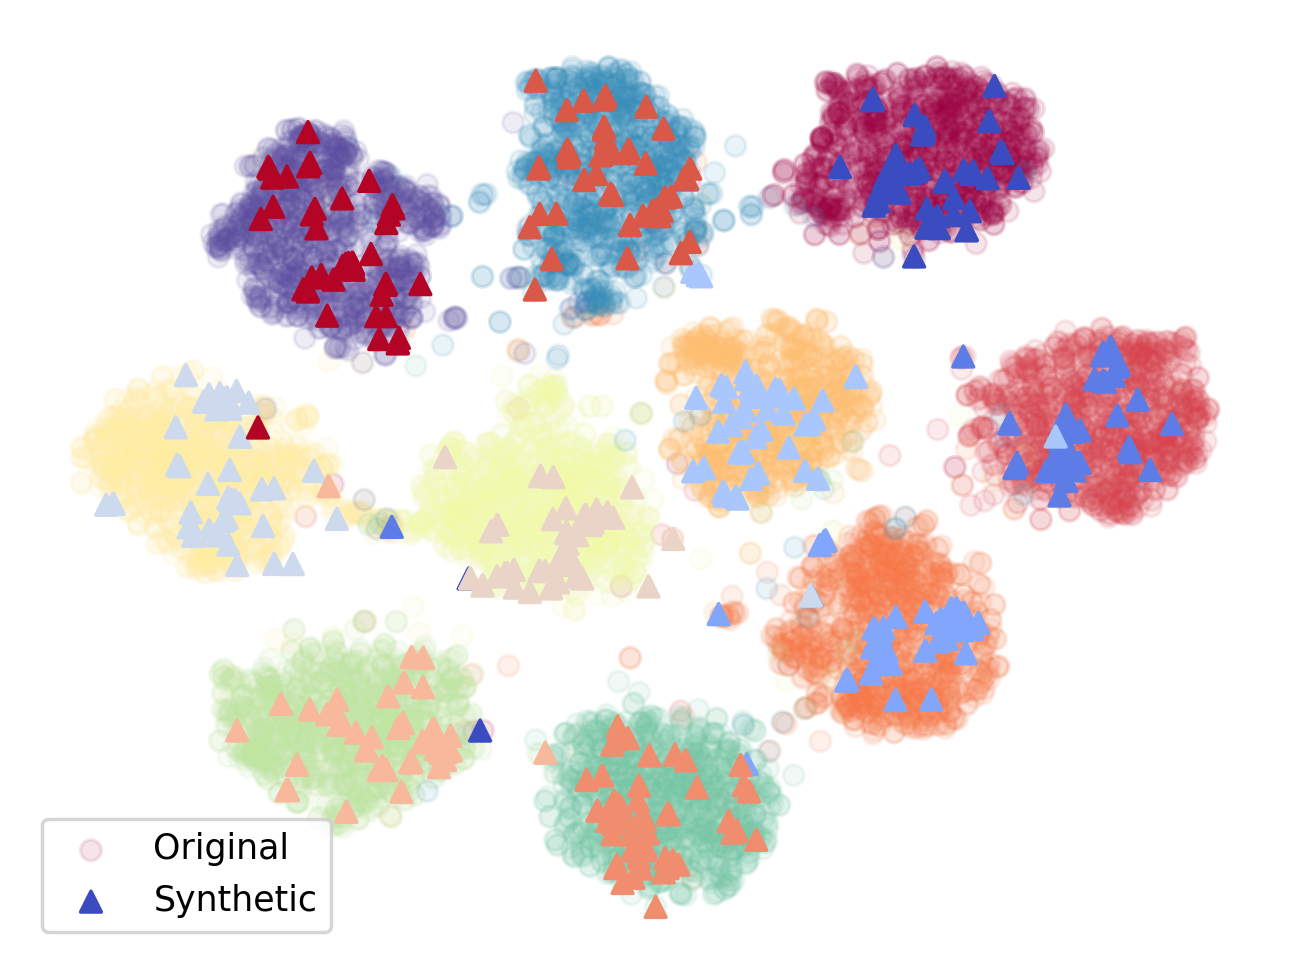

In [31]:
original_features_2d_ours = features_2d_ours[:len(train_features_ours)]
distilled_features_2d_ours = features_2d_ours[len(train_features_ours):]
original_labels = labels[:len(train_features_ours)]
distilled_labels = labels[len(train_features_ours):]

fig, ax = plt.subplots(dpi=250)
scatter1 = ax.scatter(original_features_2d_ours[:, 0], original_features_2d_ours[:, 1], cmap='Spectral', c=original_labels, alpha=0.1, label='Original')
# cbar1 = plt.colorbar(scatter1, ax=ax)
scatter2 = ax.scatter(distilled_features_2d_ours[:, 0], distilled_features_2d_ours[:, 1], cmap='coolwarm', c=distilled_labels, marker='^', label='Synthetic')
# cbar2 = plt.colorbar(scatter2, ax=ax)

plt.legend()
plt.axis('off')
plt.show()